# Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. <br>
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. <br>
В наборе данных попадается аббревиатура _ESRB (Entertainment Software Rating Board)_ — это ассоциация, определяющая возрастной рейтинг компьютерных игр. _ESRB_ оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных из файла

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 16715 entries, 0 to 16714

Data columns (total 11 columns):

Name               16713 non-null object

Platform           16715 non-null object

Year_of_Release    16446 non-null float64

Genre              16713 non-null object

NA_sales           16715 non-null float64

EU_sales           16715 non-null float64

JP_sales           16715 non-null float64

Other_sales        16715 non-null float64

Critic_Score       8137 non-null float64

User_Score         10014 non-null object

Rating             9949 non-null object

dtypes: float64(6), object(5)

memory usage: 1.4+ MB


### План
* Поменять регистр столбцов
* Решение о переводе типа данных:
    * `Year_of_Release` в тип `int`;
    * `Critic_Score` в тип `int` исходя из первичного осмотра;
    * `User_Score` в тип `float`
* Изучить пропуски в столбцах и их решение:
    * `Name`
    * `Year_of_Release`
    * `Genre`
    * `Critic_Score`
    * `User_Score`
    * `Rating`
* Дубликаты
* Анализ аномалий, их визуализация по необходимости

## Подготовка данных

In [5]:
# Переведем в нижний регистр все названия колонок:

df.columns = df.columns.str.lower()
df.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN


### Перевод данных в другой тип

In [6]:
# Переведем год в целый тип:
df['year_of_release'] = df['year_of_release'].astype('Int64')

# переведем оценки критиков в целочисленный тип:
#df['critic_score'] = df['critic_score'].astype('Int64')

print('Тип данных у года выхода игры:', df['year_of_release'].dtype)
print('Тип данных у оценки критиков:', df['critic_score'].dtype)

Тип данных у года выхода игры: Int64

Тип данных у оценки критиков: float64


### Пропуски

In [7]:
print(df.isna().sum())

name                  2

platform              0

year_of_release     269

genre                 2

na_sales              0

eu_sales              0

jp_sales              0

other_sales           0

critic_score       8578

user_score         6701

rating             6766

dtype: int64


In [8]:
# Сперва изучим наименование игр, где у нас два пропуска:

df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


* Удалять эти строки не нужно, ведь в них есть данные по продажам (хоть и маленькие), поэтому все пропуски в этих двух строках заменим на нули. В колоке жанр и наименование пропуски можно заменить на `unknown`.

In [9]:
df['name'] = df['name'].fillna('unknown')
df['genre'] = df['genre'].fillna('unknown')

df[df['name'] == 'unknown']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,unknown,GEN,1993,unknown,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,unknown,GEN,1993,unknown,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пока в численных показателях не буду заполнять пропуски, прежде не проанализировав пропуски во всех остальных пропусках.

In [10]:
df.corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
year_of_release,1.000000,-0.092500,0.003978,-0.168366,0.037820,0.011411
na_sales,-0.092500,1.000000,0.765335,0.449594,0.638649,0.240755
eu_sales,0.003978,0.765335,1.000000,0.435061,0.722792,0.220752
jp_sales,-0.168366,0.449594,0.435061,1.000000,0.291089,0.152593
other_sales,0.037820,0.638649,0.722792,0.291089,1.000000,0.198554
critic_score,0.011411,0.240755,0.220752,0.152593,0.198554,1.000000


In [11]:
df['user_score'].value_counts().head()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
Name: user_score, dtype: int64

* Оценки критиков и оценки пользователей ни с чем не коррелируют, поэтому заполнять эти пропуски, группируя по каким-то данным нет смысла.
* Загуглив значение аббревиатуры `tbd`, узнала расшифровку: *To Be Decided (в перевод. с английского "Будет решено/определено"*. Можно сделать предположение, что это игры поздних годов (2016). Надо изучить.

In [12]:
df[df['user_score'] == 'tbd'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E


In [13]:
(df.groupby('year_of_release', group_keys=False)
 .apply(lambda df: df.query('user_score == "tbd"'))['name'].count())

2376

In [14]:
df.query('user_score == "tbd"').groupby('year_of_release', as_index = False).name.count()

,year_of_release,name
0,1997,1
1,1999,8
2,2000,43
3,2001,82
4,2002,192
5,2003,95
6,2004,107
7,2005,121
8,2006,124
9,2007,192


* Предположение оказалось неверным, тогда просто заменим на `NaN`, чтобы можно было перевести колонку в целочисленный тип и делать вычисления.

In [15]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

print('Тип данных у оценок пользователей:', df['user_score'].dtype)

Тип данных у оценок пользователей: float64


### Дубликаты

In [16]:
df.duplicated().sum()

0

* Ура! Явных дубликатов нет.

### Подсчет суммарных продаж

In [17]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы. 

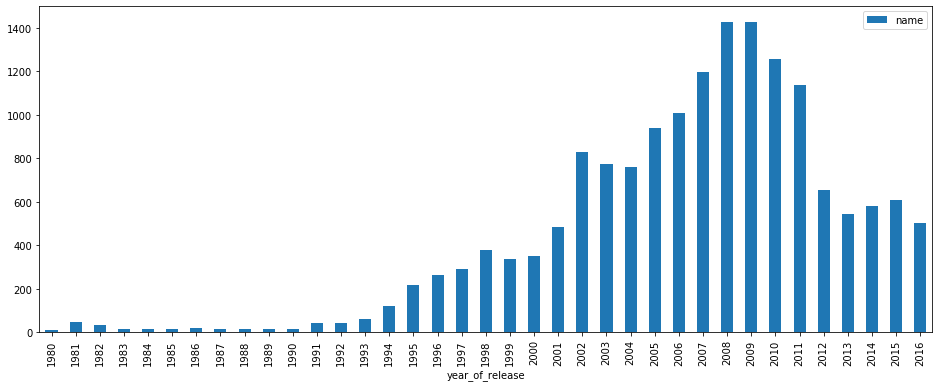

In [18]:
games_per_year = df.pivot_table(index='year_of_release', values='name', aggfunc='count')
games_per_year.plot(kind='bar', figsize=(16,6))

In [19]:
#games_per_year

games_per_year.query('year_of_release < 1993')['name'].sum() / games_per_year['name'].sum() * 100

1.85455429891767

* 1.85 процентов  довольно НЕбольшой объем для того, чтобы оставлять в анализе. Поэтому удолим.

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

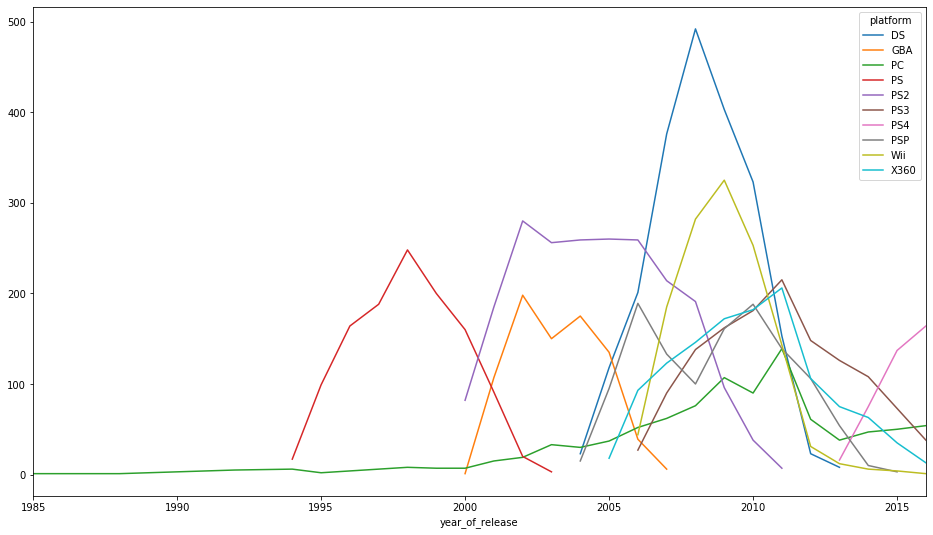

In [20]:
top_platforms = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Изменено
top_platforms_list = top_platforms[:10].index.tolist()

df[df['platform'].isin(top_platforms_list)].pivot_table(index='year_of_release',
                                                   columns='platform',
                                                  values='name',
                                                  aggfunc='count').plot(figsize=(16,9))

In [21]:
top_platforms_new = df.groupby('platform', as_index = False).total_sales.sum().sort_values(by = 'total_sales',
                                                                                           ascending=False)

# as_index - тоже самое, что и reset_index()

top_platforms_list_new = top_platforms_new.head(10)['platform'].tolist()
top_platforms_list_new

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC']

* В среднем продолжительность одной девяти самых продаваемых платформ составляет около 10 лет. Потом идет смена "поколений".
* Дополнительно было решено добавить в диаграмму PC, тк. это самая долгоживущая платформа. После 2011 годов идет спад в продажах для ПК, но начиная с 2013 года наблюдается тенденция подъема продаж игр на данной платформе.

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Исходя из среднего жизненного цикла каждой наиболее продаваемой платформы, который составляет около 10 лет, до актуальным периодом возьмем года с **2013 по 2016**

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Из ранее сделанного графика можно вывести топ-10 платформ, лидирующие по продажам:

In [22]:
top_platforms_list

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC']

В основном все лидеры продаж уже на закате. Если только взять потенциально прибыльную платформу под названием PS4. Ну и ПК.

Теперь выведем таблицу с топами платформ, но с хвоста.

In [23]:
df_actual = df.query('2012 < year_of_release <= 2016')

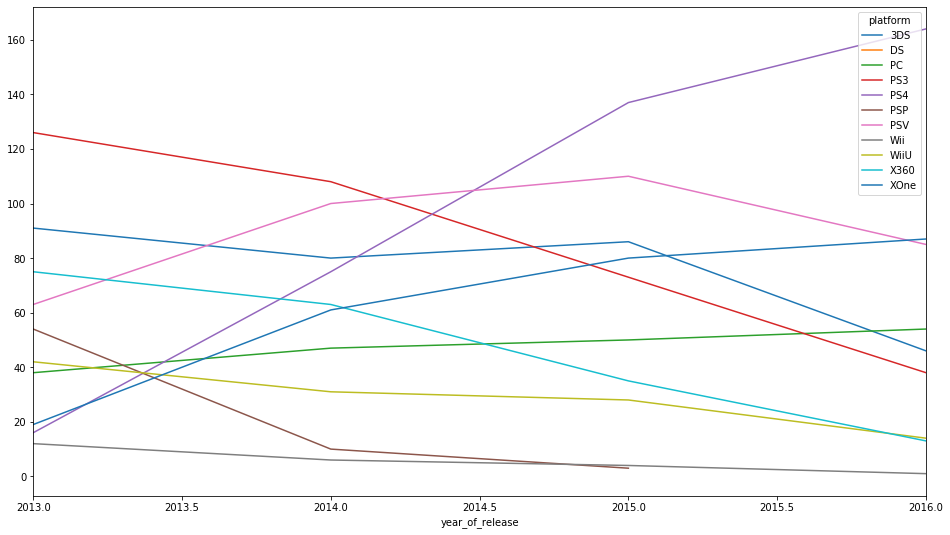

In [24]:
df_actual.pivot_table(index='year_of_release',
                      columns='platform',
                      values='name',
                      aggfunc='count').plot(figsize=(16,9))

* В актуальном периоде тенденцию роста показывают две платформы: PS4 и XOne. Остальные платформы идут на спад.

In [25]:
top_platforms.tail(10).index.tolist()

['SAT', 'GEN', 'DC', 'SCD', 'NG', 'WS', 'TG16', '3DO', 'GG', 'PCFX']

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [26]:
# Построим таблицу, вбирающая в себя все значения за 2006-2016 года.

df_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


* Отлично, теперь переходим к ящику с усами для каждой платформы (всего по 10 штукам будем строить)

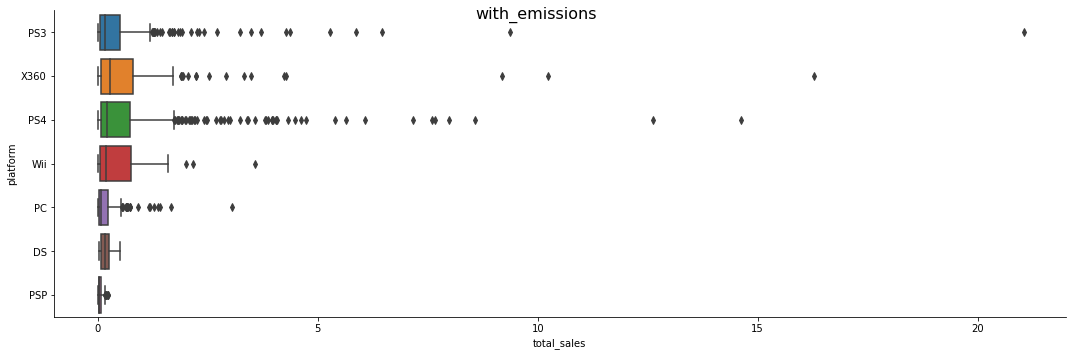

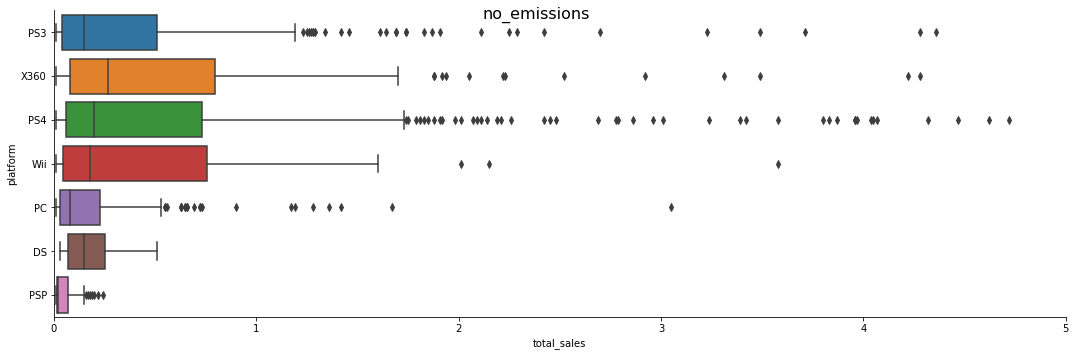

In [27]:
ax = sns.catplot(x="total_sales",
                 y="platform",
                 data=df_actual.query('platform == @top_platforms_list'),
                 height=5,
                aspect=3,
                kind='box')
ax.fig.suptitle('with_emissions', fontsize=16)
ax.set(xlim=(-1, 22))

ax = sns.catplot(x="total_sales",
                 y="platform",
                 data=df_actual.query('platform == @top_platforms_list'),
                 height=5,
                aspect=3,
                kind='box')
ax.fig.suptitle('no_emissions', fontsize=16)
ax.set(xlim=(0, 5))


#### Вывод

* Только несколько платформ могут похвастаться тем, что их диапазон нормального значения до миллиона проданных копий. Эти платформы: PS, PS4, PS3, X360
* На данном графике можно пронаблюдать, что очень много выбросов. Возможно, это выстрельнувшие хиты, которые успели выйти за 3 года.

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Возьмем в качестве примера игры на ПК.

Text(0.5, 1.0, 'critic_score_ratio_PC')

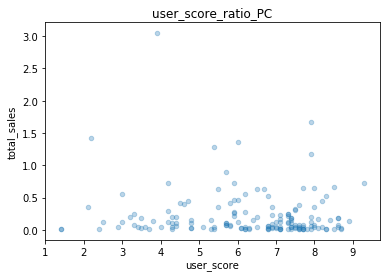

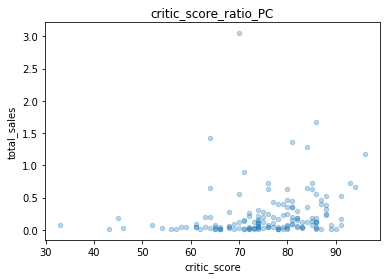

In [28]:
scores_to_sales = df_actual.query('platform == "PC"')
scores_to_sales.plot(kind='scatter', x='user_score', y='total_sales', alpha=.3)
plt.title('user_score_ratio_PC')
scores_to_sales.plot(kind='scatter', x='critic_score', y='total_sales', alpha=.3)
plt.title('critic_score_ratio_PC')

In [29]:
print('Корелляция оценки пользователей к продажам:', scores_to_sales['total_sales'].corr(scores_to_sales['user_score']))
print('Корелляция оценки критиков к продажам:', scores_to_sales['total_sales'].corr(scores_to_sales['critic_score']))

Корелляция оценки пользователей к продажам: -0.09384186952476739

Корелляция оценки критиков к продажам: 0.19603028294369382


* Как можно увидеть из диаграмм рассеяний и коэфициентам корреляции, оценка пользователей не имеет влияния на продажи игр. А вот оценка критиков уже имеет влияние, но слабое.

### Соотнесите выводы с продажами игр на других платформах.

In [30]:
scores_to_sales = df_actual.query('platform == @top_platforms_list')
scores_to_sales['platform'].unique()

array(['PS3', 'X360', 'PS4', 'Wii', 'PC', 'DS', 'PSP'], dtype=object)

Возьмем любые пять платформ из десяти самых продаваемых платформ и построим диаграммы рассеивания по оценкам критиков и оценкам пользователей.


3DS


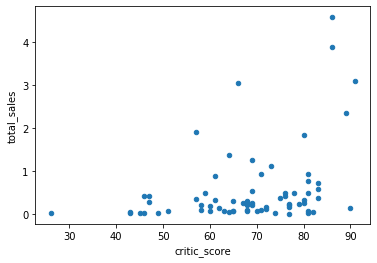

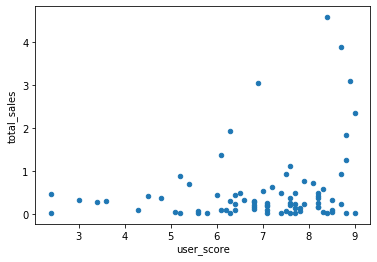

critic_score    0.357057

user_score      0.241504

total_sales     1.000000

Name: total_sales, dtype: float64


DS


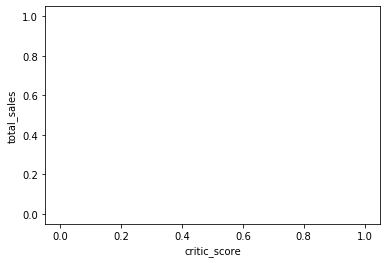

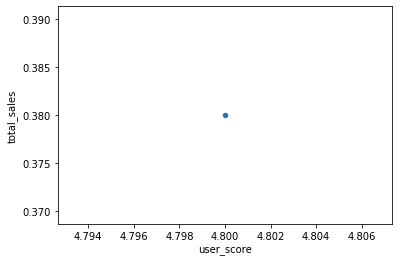

critic_score    NaN

user_score      NaN

total_sales     1.0

Name: total_sales, dtype: float64


PC


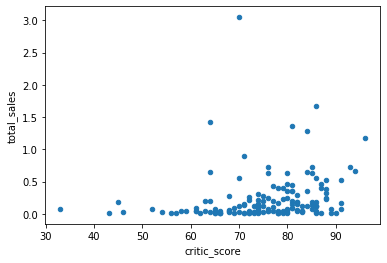

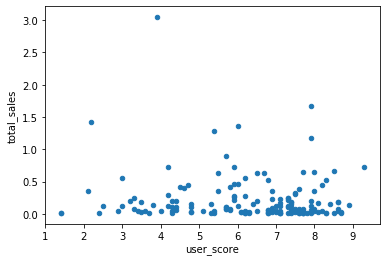

critic_score    0.196030

user_score     -0.093842

total_sales     1.000000

Name: total_sales, dtype: float64


PS3


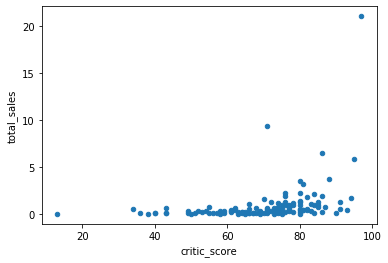

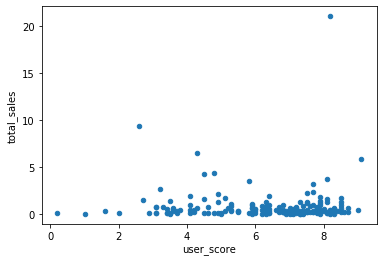

critic_score    0.334285

user_score      0.002394

total_sales     1.000000

Name: total_sales, dtype: float64


PS4


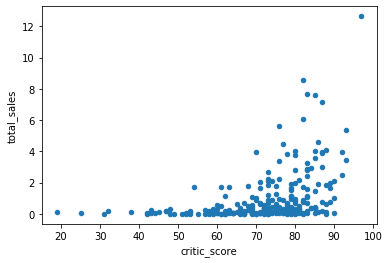

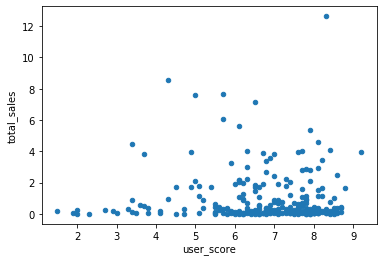

critic_score    0.406568

user_score     -0.031957

total_sales     1.000000

Name: total_sales, dtype: float64


PSP


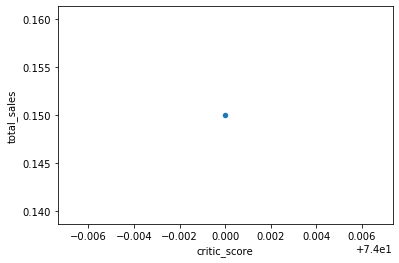

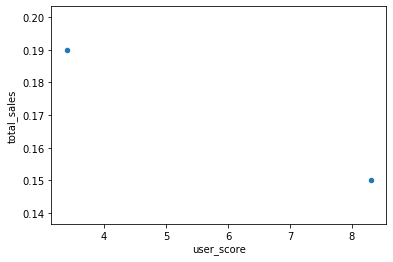

critic_score    NaN

user_score     -1.0

total_sales     1.0

Name: total_sales, dtype: float64


PSV


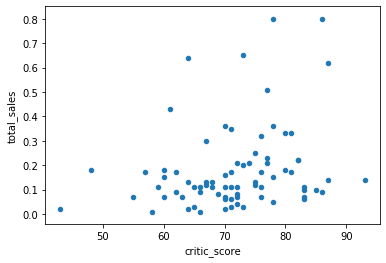

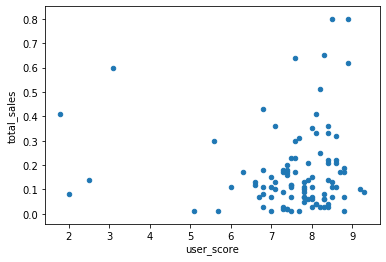

critic_score    0.254742

user_score      0.000942

total_sales     1.000000

Name: total_sales, dtype: float64


Wii


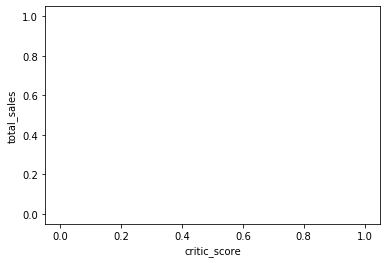

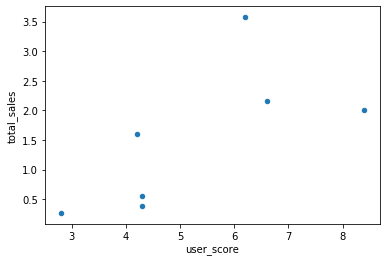

critic_score         NaN

user_score      0.682942

total_sales     1.000000

Name: total_sales, dtype: float64


WiiU


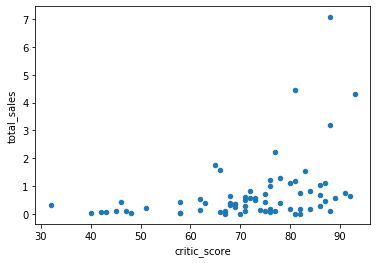

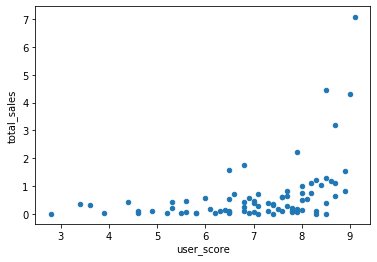

critic_score    0.376415

user_score      0.419330

total_sales     1.000000

Name: total_sales, dtype: float64


X360


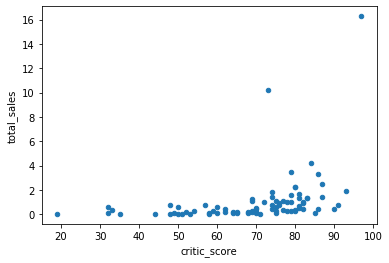

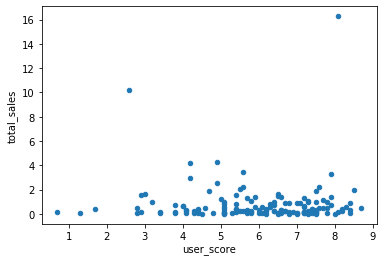

critic_score    0.350345

user_score     -0.011742

total_sales     1.000000

Name: total_sales, dtype: float64


XOne


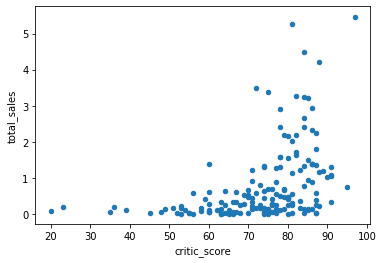

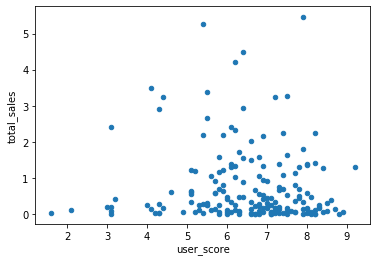

critic_score    0.416998

user_score     -0.068925

total_sales     1.000000

Name: total_sales, dtype: float64


In [31]:
for platform, scores_to_sales in df_actual.groupby('platform'):
    print('='*30)
    print(platform)
    scores_to_sales.plot(kind='scatter', x='critic_score', y='total_sales')
    scores_to_sales.plot(kind='scatter', x='user_score', y='total_sales')
    plt.show()
    print(scores_to_sales[['critic_score', 'user_score', 'total_sales']].corr()['total_sales'])

In [32]:
scores_to_sales.platform.unique()

array(['XOne'], dtype=object)

#### Вывод

* Для пользователей PS3 важна оценка только от критиков.
* Для владельцев платформы X360, PC и PS4 мнение пользователй не особо важно, а вот критиков повышает спрос
* На Wii так мало продаж в актуальном периоде, что сумма продаж не зависит от оценки игроков.
* Исходя из матрицы корреляции, оценка критикаа имеет слабое влияние. Оценка пользователя имеет обратную корреляцию.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

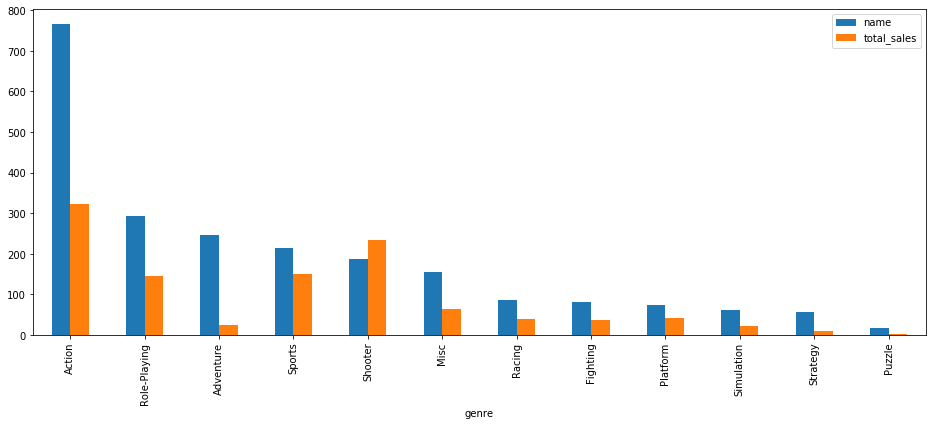

In [33]:
# Сгруппирую по жанру и построю график по кол-ву вышедших игр и их продажам

(df_actual.groupby('genre')
 .agg({'name': 'count', 'total_sales': 'sum'})
 .sort_values('name', ascending=False)
 .plot(kind='bar', figsize=(16, 6))
)

#### Вывод

* Самый прибыльный жанр и чаще всего выпускающийся - Action
* Адвенчуры имеют среднюю популярность, но низкий доход. Можно предположить, что это инди-игры с низким "ценником"
* Платформеры хоть и менее популярны, чем адвенчуры, но в разы доходнее;
* Пазлы наименее популярны и приносят одни из самых маленьких доходов;
* Хоть спортивных игр меньше экш-игр, но они более доходны, чем экшены:
* Шутеры самые окупаемые игры.

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)  для пользователя каждого региона (NA, EU, JP)

Text(0.5, 1.0, 'Japan')

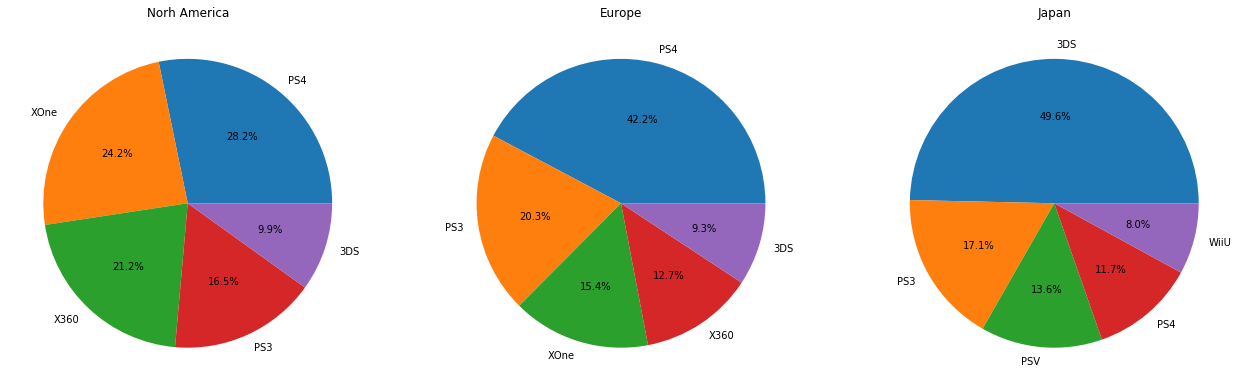

In [34]:
# Группирую по платформам и считаю сумму продаж по каждому региону

na_sales = (df_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum')
           .sort_values('na_sales', ascending=False)).reset_index()
na_sales = na_sales.iloc[:5]

eu_sales = (df_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
           .sort_values('eu_sales', ascending=False)).reset_index()
eu_sales = eu_sales.iloc[:5]

jp_sales = (df_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
           .sort_values('jp_sales', ascending=False)).reset_index()
jp_sales = jp_sales.iloc[:5]

x1 = na_sales['na_sales']
x2 = eu_sales['eu_sales']
x3 = jp_sales['jp_sales']

fig, ax = plt.subplots(1, 3, figsize=(22,22))

ax[0].pie(x1, labels=na_sales['platform'], autopct='%1.1f%%')
ax[0].set_title('Norh America')

ax[1].pie(x2, labels=eu_sales['platform'], autopct='%1.1f%%')
ax[1].set_title('Europe')

ax[2].pie(x3, labels=jp_sales['platform'], autopct='%1.1f%%')
ax[2].set_title('Japan')

**Топ 5 платформ в Северной Америке**
1. PS4
2. XOne
3. X360
4. PS3
5. 3DS

**Топ 5 платформ в Европе**
1. PS4
2. PS3
3. XOne
4. X360
5. 3DS

**Топ 5 платформ в Японии**
1. 3DS
2. PS3
3. PSV
4. PS4
5. WiiU

### Самые популярные жанры (топ-5)

Text(0.5, 1.0, 'Japan')

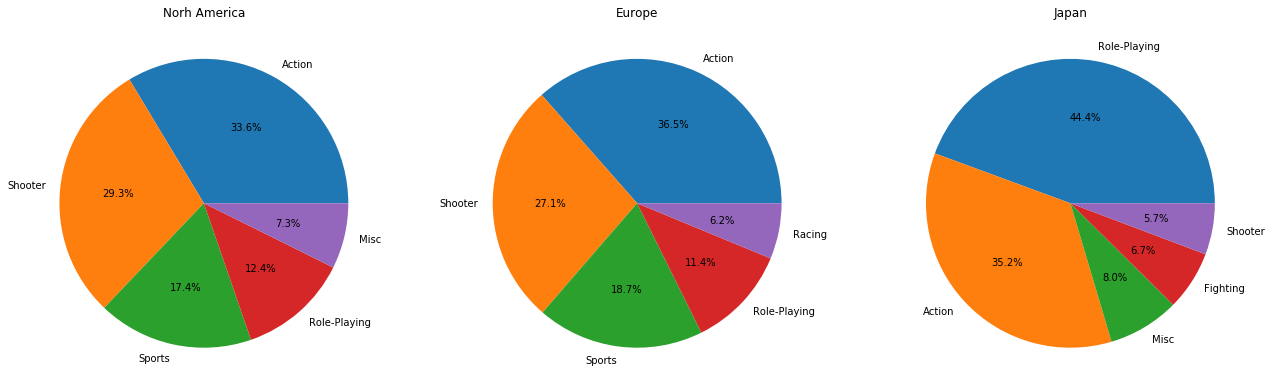

In [35]:
# Группирую по жанру и считаю суммы продаж по каждому региону

na_sales = (df_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum')
           .sort_values('na_sales', ascending=False)).reset_index()
na_sales = na_sales.iloc[:5]

eu_sales = (df_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
           .sort_values('eu_sales', ascending=False)).reset_index()
eu_sales = eu_sales.iloc[:5]

jp_sales = (df_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
           .sort_values('jp_sales', ascending=False)).reset_index()
jp_sales = jp_sales.iloc[:5]

x1 = na_sales['na_sales']
x2 = eu_sales['eu_sales']
x3 = jp_sales['jp_sales']

fig, ax = plt.subplots(1, 3, figsize=(22,22))

ax[0].pie(x1, labels=na_sales['genre'], autopct='%1.1f%%')
ax[0].set_title('Norh America')

ax[1].pie(x2, labels=eu_sales['genre'], autopct='%1.1f%%')
ax[1].set_title('Europe')

ax[2].pie(x3, labels=jp_sales['genre'], autopct='%1.1f%%')
ax[2].set_title('Japan')

**Топ 5 популярных жанров в Северной Америке**
1. Action
2. Sports
3. Shooter
4. Role-play
5. Misc

**Топ 5 популярных жанров в Европе**
1. Action
2. Shooter
3. Sports
4. Role-play
5. Racing

**Топ 5 популярных жанров в Японии**
1. Role-play
2. Action
3. Misc
4. Fighting
5. Shooter

#### Вывод

Жанровые предпочтение в Северной Америке и Европе схожи. А вот в Японии имеются сильные различия. Самый популярный жанр в японии РПГ, это можно обусловить тем, что изначально Япония развивалась с этой стороны, взять даже отдельных жанр J-RPG, который , скорее всего, тоже входит в РПГ в данном анализе. Плюсом выступает разница в культурах, поэтому тоже можно наблюдать такие различия между Западом и Востоком.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  


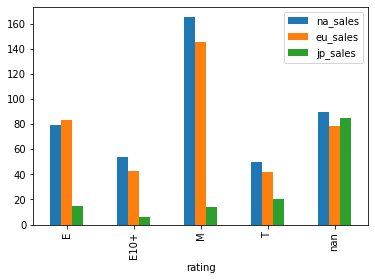

In [36]:
# Группирую по рейтингу и считаю общие продажи с каждого региона
df_actual['rating'] = df_actual['rating'].astype('str')

region_rating = df_actual.groupby('rating').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum'})
region_rating.plot(kind='bar')

#### Вывод
Действительно, чем ниже рейтинг (т.е. насколько больше происходит охват аудитории) - тем выше продажи. Работает это в каждом региона почти одинаково (кроме Японии). У Японии самые высокие продажи с рейтингом *E*, а оставшиеся 4 рейтинга имеют одинаковый уровень продаж, кроме *T*. Также можно заметить, что игры, у которых не определен рейтин, также очень большое кол-во продаж (кэп).

## Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Т.к. альтернативная гипотеза строится на неравенстве, то нулевую построим на равенстве: *средние оценки двух платформ одинаковые.*
<br>
Альтернативная гипотеза: *средние пользовательские рейтинги платформы Xbox One и PC различаются.*

In [37]:
xbox = df_actual[df_actual['platform'] == 'XOne']['user_score'].dropna()
pc = df_actual[df_actual['platform'] == 'PC']['user_score'].dropna()

alpha = .05

results = st.ttest_ind(
    xbox,
    pc
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.14012658403611647

Не получилось отвергнуть нулевую гипотезу


* Делаем вывод, что оценки пользователей двух платформ не отличаются.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая теория будет звучать так: *средние пользовательские рейтинги перечисленных жанров равны.*
<br>
Альтернативная гипотеза: *средние пользовательские рейтинги перечисленных жанров различаются"

А в качестве критерия будем использовать p-value и ttest'ы.

In [38]:
action = df_actual[df_actual['genre'] == 'Action']['user_score'].dropna()
sports = df_actual[df_actual['genre'] == 'Sports']['user_score'].dropna()

results = st.ttest_ind(
    action,
    sports
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 1.0517832389140023e-27

Отвергаем нулевую гипотезу


* Средние пользовательские оценки для двух жанров различаются.

## Общий вывод

* Если выбирать западный рынок, то лучше выбирать жанры экшен, шутер
* Если выбирать японский рынок, то подойдет РПГ, но, опять же, со спецификой японского менталитета.
* Среди экшн игр огромная конкуренция, если шанс остаться незамеченными
* У шутеров и платформеров высокая окупаемость, т.к. на фоне кол-ва экшенов их меньше
* В северной америке  стоит выпускать игры на PS4 и консоли от Microsoft.
* В европе есть спрос и есть тенденция на рост PS4, овольно перспективной консоли. PS3 все еще в тренде.
* Для Японского рынка стоит выпускать игры на крайне популярную консоль 3DS, также в тренде остается PS3 и PSV.